In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

(3000, 32, 32, 3)
(3000,)
(300, 32, 32, 3)


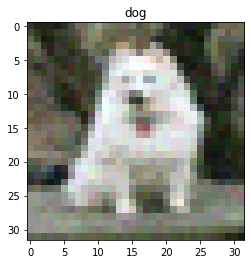

In [3]:
with np.load('/content/drive/My Drive/DL data/CNN/prediction-challenge-02-data.npz') as fh:
    x_train = fh['x_train']
    y_train = fh['y_train']
    x_test = fh['x_test']

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

classes = ['cat', 'dog', 'frog']
plt.imshow(x_train[50])
plt.title(classes[int(y_train[50])])
plt.show()

In [7]:
split = int(0.8*len(x_train))        # 80/20 split of train data into training and validation data
train_x = torch.Tensor(x_train[:split])
valid_x = torch.Tensor(x_train[split:])
train_y = torch.Tensor(y_train[:split])
valid_y = torch.Tensor(y_train[split:])

train = TensorDataset(train_x, train_y)
trainloader = DataLoader(train, batch_size=25, shuffle=True)

val = TensorDataset(valid_x,valid_y)
valloader = DataLoader(val, batch_size=25, shuffle=True)

In [4]:
class Conv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.MaxPool2d(2, 2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.MaxPool2d(2, 2))
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(8*8*64, 120),
            torch.nn.ReLU(inplace=True))
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(120, 3))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 8*8*64)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

net = Conv()
print(net)

Conv(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=4096, out_features=120, bias=True)
    (1): ReLU(inplace=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=3, bias=True)
  )
)


In [5]:
optim = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.8)
loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
epochs = 30

for epoch in range(epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.detach().numpy()
        inputs = np.moveaxis(inputs, -1, 1)
        inputs = torch.Tensor(inputs)
        optim.zero_grad()

        pred = net(inputs)
        loss = loss_fn(pred, labels.long())
        loss.backward()
        optim.step()

    print(f'iteration:{epoch}\tCross Entropy Loss:{loss.item()}')


iteration:0	Cross Entropy Loss:0.9640272259712219
iteration:1	Cross Entropy Loss:0.7903423309326172
iteration:2	Cross Entropy Loss:0.7545167803764343
iteration:3	Cross Entropy Loss:0.7679311633110046
iteration:4	Cross Entropy Loss:0.7847170829772949
iteration:5	Cross Entropy Loss:0.643480122089386
iteration:6	Cross Entropy Loss:0.8003828525543213
iteration:7	Cross Entropy Loss:0.5486409664154053
iteration:8	Cross Entropy Loss:0.6705785393714905
iteration:9	Cross Entropy Loss:0.842628538608551
iteration:10	Cross Entropy Loss:0.5587964057922363
iteration:11	Cross Entropy Loss:0.8242346048355103
iteration:12	Cross Entropy Loss:0.770469605922699
iteration:13	Cross Entropy Loss:0.5806024670600891
iteration:14	Cross Entropy Loss:0.5893694162368774
iteration:15	Cross Entropy Loss:0.6012355089187622
iteration:16	Cross Entropy Loss:0.5430784821510315
iteration:17	Cross Entropy Loss:0.6858078241348267
iteration:18	Cross Entropy Loss:0.5559127926826477
iteration:19	Cross Entropy Loss:0.6124011874

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        inputs = inputs.detach().numpy()
        inputs = np.moveaxis(inputs, -1, 1)
        inputs = torch.Tensor(inputs)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on train data: %d %%' % (100 * correct / total))

Accuracy on train data: 87 %


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        inputs, labels = data
        inputs = inputs.detach().numpy()
        inputs = np.moveaxis(inputs, -1, 1)
        inputs = torch.Tensor(inputs)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test data: %d %%' % (100 * correct / total))

Accuracy on test data: 73 %


In [13]:
_, prediction = net(torch.Tensor(x_test).view(-1, 3, 32, 32)).max(dim=-1)

In [14]:
assert prediction.ndim == 1         # as required for submission
assert prediction.shape[0] == 300

In [15]:
np.save('prediction.npy', prediction)
from google.colab import files
files.download('prediction.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>